# Importing Packages

In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

# For Logistic Regression
from sklearn.linear_model import LogisticRegression


# For Support Vector Classification (SVC)
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# For Decision Trees and Random Forest
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Boosting
from sklearn.ensemble import AdaBoostClassifier

# For Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

# Metrics
from sklearn import metrics
from sklearn.metrics import roc_curve, auc                      
from sklearn.metrics import roc_auc_score, accuracy_score       
from sklearn.metrics import matthews_corrcoef                   
from sklearn.metrics import confusion_matrix                    
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# EDA and Pre-processing

In [2]:
df_og = pd.read_csv("diabetes.csv")
data = df_og.to_numpy()

print(f"The shape for the originial dataframe: {df_og.shape}")
print(f"The shape for the dataframe with dropping NaN: {df_og.dropna().shape}")

The shape for the originial dataframe: (253680, 22)
The shape for the dataframe with dropping NaN: (253680, 22)


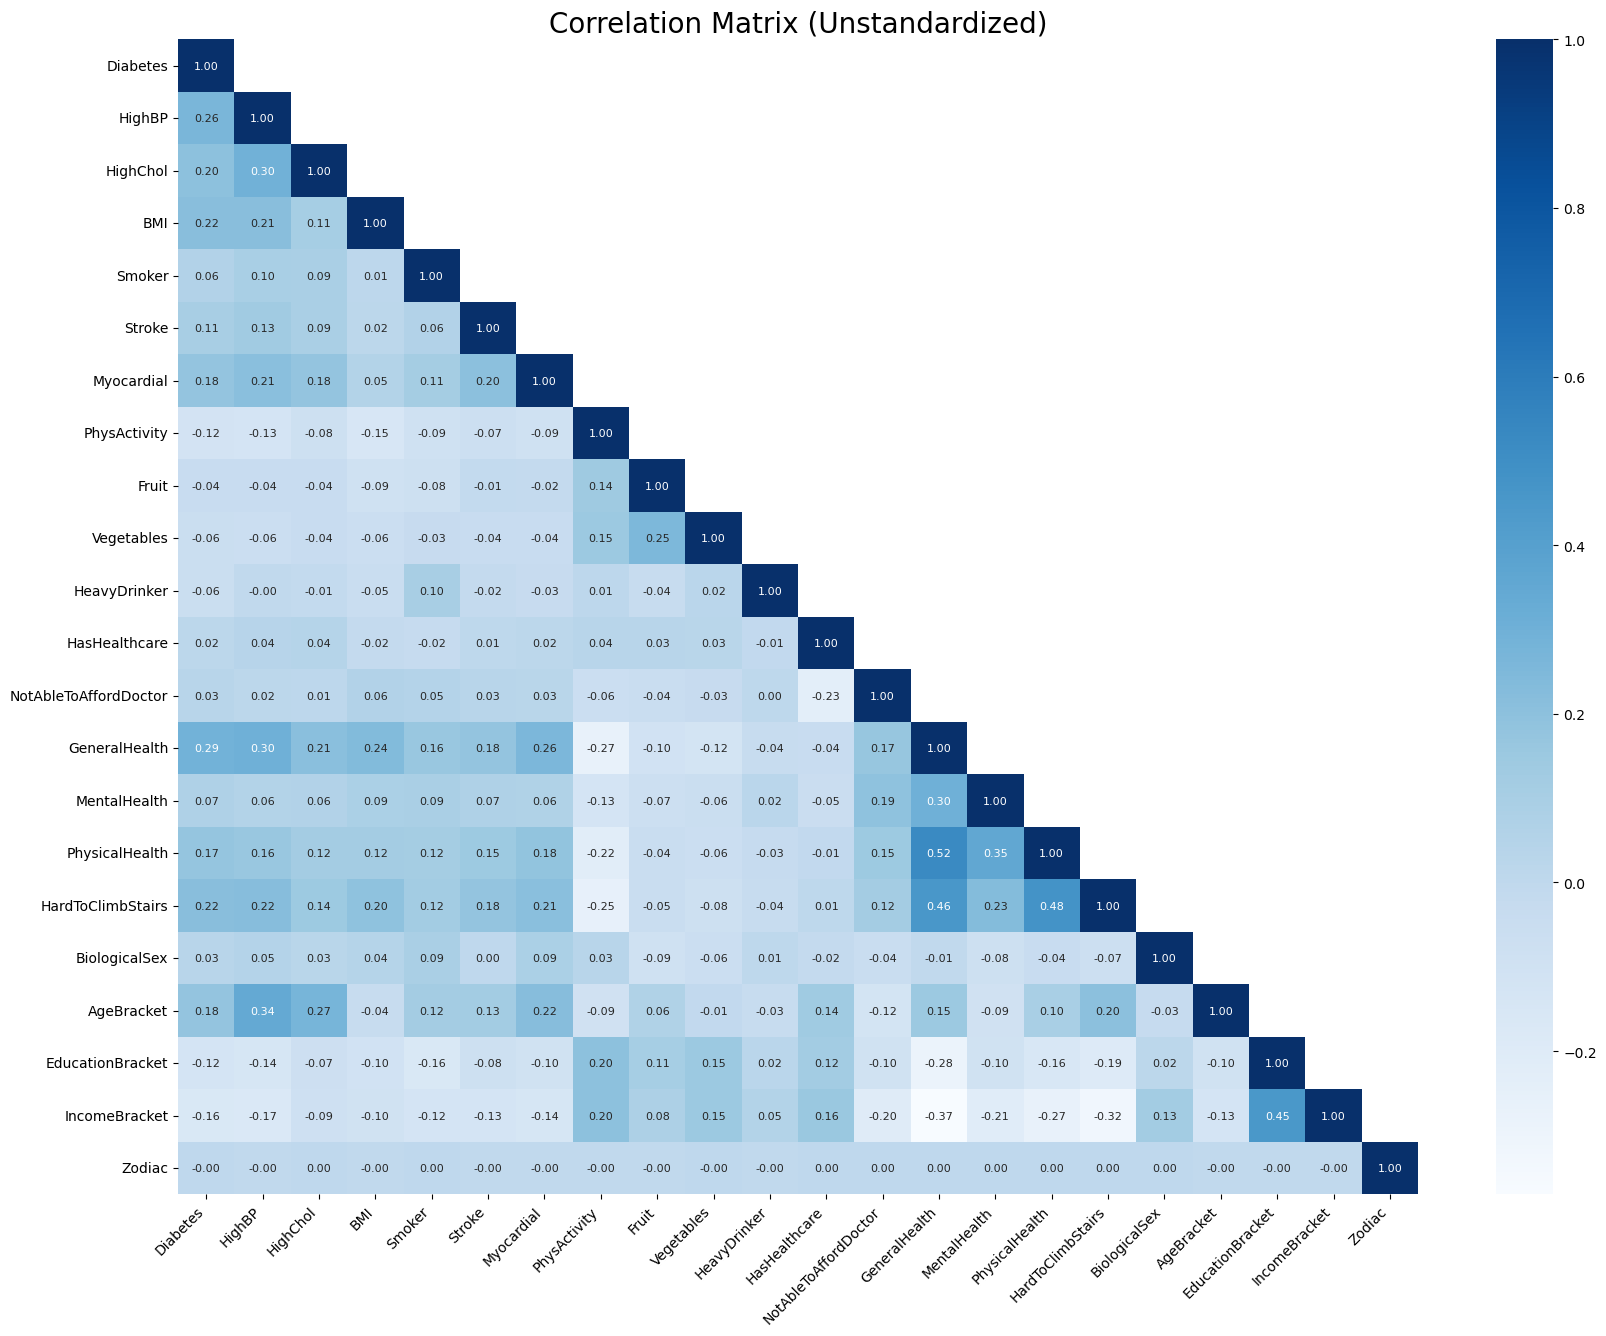

In [3]:
correlation_matrix = pd.DataFrame(df_og).corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cbar=True, cmap="Blues", annot_kws={'size': 8}, mask=mask)
plt.title('Correlation Matrix (Unstandardized)', fontsize=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [4]:
# Change encoding: 1 = male to 1, 2 = female to 0
df_og['BiologicalSex'] = df_og['BiologicalSex'].map({1: 1, 2: 0})

df_og.rename(columns={'BiologicalSex': 'Male'}, inplace=True)

In [5]:
# One-hot encode
df = pd.get_dummies(df_og, columns=['AgeBracket', 'EducationBracket', 'IncomeBracket', 'Zodiac'], prefix=['Age', 'Education', 'Income', 'Zodiac'])

new_column_names = {
    'Age_1': 'Age 18-24', 'Age_2': 'Age 25-29', 'Age_3': 'Age 30-34', 'Age_4': 'Age 35-39',
    'Age_5': 'Age 40-44', 'Age_6': 'Age 45-49', 'Age_7': 'Age 50-54', 'Age_8': 'Age 55-59',
    'Age_9': 'Age 60-64', 'Age_10': 'Age 65-69', 'Age_11': 'Age 70-74', 'Age_12': 'Age 75-79', 'Age_13': 'Age 80+',
    'Education_1': 'Kindergarten', 'Education_2': 'Elementary School', 'Education_3': 'Some High School',
    'Education_4': 'GED', 'Education_5': 'Some College', 'Education_6': 'College Graduate',
    'Income_1': 'Below $10k', 'Income_2': '$10k-$15k', 'Income_3': '$15k-$20k', 'Income_4': '$20k-$25k',
    'Income_5': '$25k-$35k', 'Income_6': '$35k-$50k', 'Income_7': '$50k-$75k', 'Income_8': 'Above $75k',
    'Zodiac_1': 'Aries', 'Zodiac_2': 'Taurus', 'Zodiac_3': 'Gemini', 'Zodiac_4': 'Cancer',
    'Zodiac_5': 'Leo', 'Zodiac_6': 'Virgo', 'Zodiac_7': 'Libra', 'Zodiac_8': 'Scorpio',
    'Zodiac_9': 'Sagittarius', 'Zodiac_10': 'Capricorn', 'Zodiac_11': 'Aquarius', 'Zodiac_12': 'Pisces'
}

df.rename(columns=new_column_names, inplace=True)
df.head()


,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,Gemini,Cancer,Leo,Virgo,Libra,Scorpio,Sagittarius,Capricorn,Aquarius,Pisces
0,0,1,1,40,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,25,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,1,28,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,27,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
4,0,1,1,24,0,0,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# Columns to drop
columns_to_drop = ['Pisces', 'Above $75k', 'Some College', 'Age 80+']

# Dropping the columns from the DataFrame
df = df.drop(columns=columns_to_drop)

In [7]:
# Looking at moderate correlation 
corr_matrix = df.corr()

# Find pairs of variables with correlation >= 0.5
high_corr_var = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Correlation'])
for row in corr_matrix.columns:
    for col in corr_matrix.index:
        if (corr_matrix[row][col] >= 0.3) and (row != col):
            high_corr_var = high_corr_var.append({'Variable 1': row, 'Variable 2': col, 'Correlation': corr_matrix[row][col]}, ignore_index=True)

# Removing duplicate pairs
high_corr_var = high_corr_var.drop_duplicates(subset=['Correlation'])
high_corr_var = high_corr_var.reset_index(drop=True)

high_corr_var.sort_values(by = "Correlation", ascending = False)

/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/122487291.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_var = high_corr_var.append({'Variable 1': row, 'Variable 2': col, 'Correlation': corr_matrix[row][col]}, ignore_index=True)
/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/122487291.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_var = high_corr_var.append({'Variable 1': row, 'Variable 2': col, 'Correlation': corr_matrix[row][col]}, ignore_index=True)
/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/122487291.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_var = high_corr_var.append({'Variable 1': row, 'Variable 2': col, 'Correla

,Variable 1,Variable 2,Correlation
2,GeneralHealth,PhysicalHealth,0.524364
5,PhysicalHealth,HardToClimbStairs,0.478417
3,GeneralHealth,HardToClimbStairs,0.456920
4,MentalHealth,PhysicalHealth,0.353619
1,GeneralHealth,MentalHealth,0.301674
0,HighBP,GeneralHealth,0.300530


In [8]:
# Checking the balance of the dataset with respect to diabetes
diabetes_counts = df['Diabetes'].value_counts()
print(diabetes_counts)

# Accuracy score from always guessing no diabetes
always_no_diabetes = round((diabetes_counts[0]/df.shape[0])*100, 2)
print(f"Accuracy from always guessing no diabetes: {always_no_diabetes}%")


0    218334
1     35346
Name: Diabetes, dtype: int64
Accuracy from always guessing no diabetes: 86.07%


# Question 1

In [11]:
X = df.drop('Diabetes', axis=1)  # Features
y = df['Diabetes']  # Outcome


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variables to be scaled
variables_to_scale = ['BMI', 'MentalHealth', 'PhysicalHealth']


scaler = StandardScaler()

# Apply scaling to the selected variables in the training set
X_train_scaled = X_train.copy()
X_train_scaled[variables_to_scale] = scaler.fit_transform(X_train[variables_to_scale])

# Transform the testing set based on the parameters learned from the training set
X_test_scaled = X_test.copy()
X_test_scaled[variables_to_scale] = scaler.transform(X_test[variables_to_scale])

# Building the Logistic Regression model on standardized data
log_reg = LogisticRegression(max_iter=10000, class_weight= "balanced")
log_reg.fit(X_train_scaled, y_train)

# Model evaluation using the standardized test data
y_pred = log_reg.predict(X_test_scaled)                    # Binary estimates
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probability estimates

# AUC Curve and MCC
auc_score1 = roc_auc_score(y_test, y_pred_proba)
mcc1 = matthews_corrcoef(y_test, y_pred)  # Calculate MCC

print(f"AUC of the Logistic Regression model: {auc_score1:.3f}")
print(f"Matthews Correlation Coefficient: {round(mcc1,4)}\n")

acc_training_lr = round(log_reg.score(X_train_scaled, y_train),4)
acc_test_lr = round(log_reg.score(X_test_scaled, y_test), 4)

print(f"Accuracy on training set: {acc_training_lr}")
print(f"Accuracy on test set: {acc_test_lr}")

AUC of the Logistic Regression model: 0.828
Matthews Correlation Coefficient: 0.3627

Accuracy on training set: 0.7311
Accuracy on test set: 0.7303


In [12]:
# Initialize a dictionary to store the AUCs
auc_scores_lr = {}

# Iterate over each column to drop it and evaluate the model
for column in X.columns:
    # Drop the current column from both training and testing sets
    X_train_dropped = pd.DataFrame(X_train_scaled, columns=X.columns).drop(column, axis=1)
    X_test_dropped = pd.DataFrame(X_test_scaled, columns=X.columns).drop(column, axis=1)
    
    # Initialize and train the Logistic Regression model
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train_dropped, y_train)
    
    # Predict probabilities for AUC
    y_pred_proba_lr = lr.predict_proba(X_test_dropped)[:, 1]
    
    # Calculate AUC
    auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
    
    # Store the AUC score
    auc_scores_lr[column] = auc_lr


In [13]:
auc_scores_lr_df = pd.DataFrame(list(auc_scores_lr.items()), columns=['Feature Dropped', 'AUC'])
auc_scores_lr_df_sorted = auc_scores_lr_df.sort_values(by='AUC', ascending=True)
auc_scores_lr_df_sorted.head(10)

,Feature Dropped,AUC
12,GeneralHealth,0.811332
2,BMI,0.813955
0,HighBP,0.819646
1,HighChol,0.821449
9,HeavyDrinker,0.825613
19,Age 30-34,0.825914
20,Age 35-39,0.825944
16,Male,0.826301
18,Age 25-29,0.826350
17,Age 18-24,0.826645


/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/3167151897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC', y='Feature Dropped', data=top_10_features_lr, palette='Blues_d')


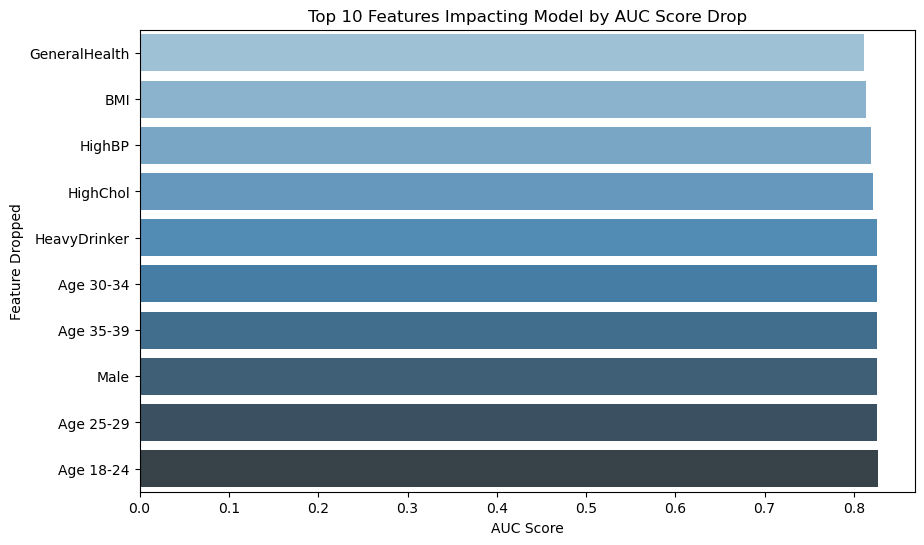

In [14]:
top_10_features_lr = auc_scores_lr_df_sorted.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Feature Dropped', data=top_10_features_lr, palette='Blues_d')
plt.title('Top 10 Features Impacting Model by AUC Score Drop')
plt.xlabel('AUC Score')
plt.ylabel('Feature Dropped')
plt.show()

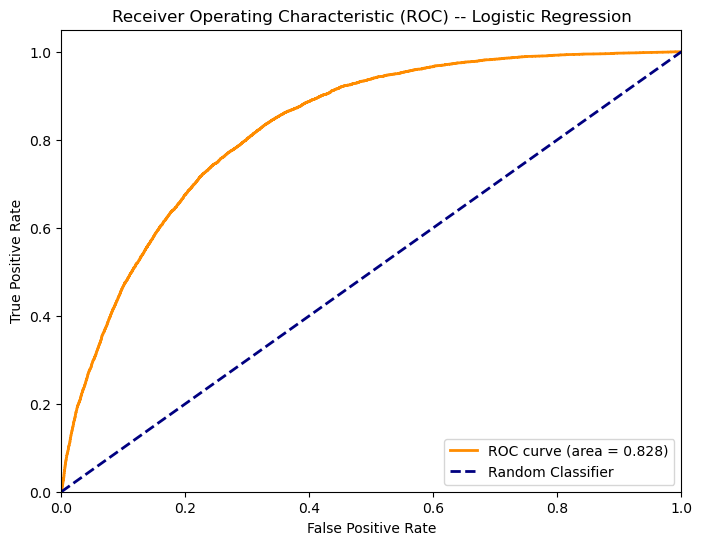

In [15]:
# Calculating the False Positive Rate (FPR), True Positive Rate (TPR), and ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)  # Now auc refers to the function correctly

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = "Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) -- Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Classification Report for Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43739
           1       0.31      0.78      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.73      0.77     50736



/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/3129273490.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Negative', 'Positive'])
/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/3129273490.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Negative', 'Positive'])


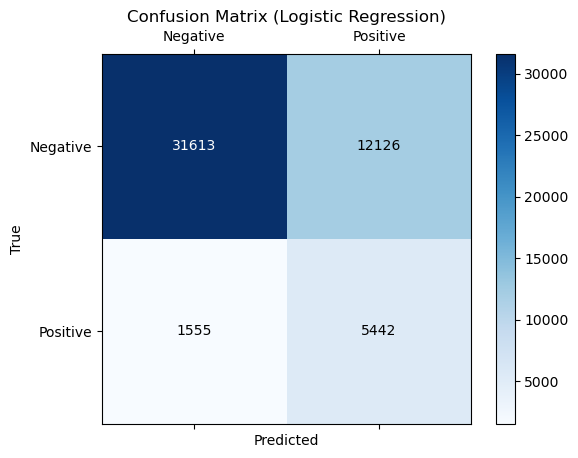

In [16]:
# Generating predictions for the test set
y_pred = log_reg.predict(X_test_scaled)

# Creating the classification report
report = classification_report(y_test, y_pred)

print("Classification Report for Logistic Regression Model:")
print(report)

# I'm using this method for the confusion matrix because plotting it with seaborn wasn't giving me the right plot

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xticklabels([''] + ['Negative', 'Positive'])
ax.set_yticklabels([''] + ['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Logistic Regression)')

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
plt.show()

# Question 2

In [17]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = np.array([class_weights[i] for i in y_train])

# Define the model
svm = LinearSVC(dual=False)

### Finding the best C value ###
# Define a range of C values to test
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Define the scoring function to be AUC score
scorer = make_scorer(roc_auc_score)

# Note: GridSearchCV does not support passing sample_weight directly
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring=scorer, cv=5)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weights)  # Adjusting for imbalance

# Best C value
best_C = grid_search.best_params_['C']
print(f"Best C value: {best_C}")

# Best score
best_score = grid_search.best_score_
print(f"Best cross-validated AUC: {best_score:.3f}")

### Building the Model ###

# Re-train the model with the best C value, adjusting for imbalance
svm_best = LinearSVC(C=best_C, dual=False)
svm_best.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Evaluate on the test set
y_pred_best = svm_best.predict(X_test_scaled)
acc_best = accuracy_score(y_test, y_pred_best)
mcc_svm = matthews_corrcoef(y_test, y_pred_best)

print(f'Linear SVM validation accuracy with best C = {best_C}: {100*acc_best:.2f}%')
print(f"Matthews Correlation Coefficient with best C = {best_C}: {round(mcc_svm,4)}\n")

acc_training_svm = round(svm_best.score(X_train_scaled, y_train), 4)
acc_test_svm = round(svm_best.score(X_test_scaled, y_test), 4)

print(f"Accuracy on training set: {acc_training_svm}")
print(f"Accuracy on test set: {acc_test_svm}")

Best C value: 10
Best cross-validated AUC: 0.745
Linear SVM validation accuracy with best C = 10: 72.65%
Matthews Correlation Coefficient with best C = 10: 0.3614

Accuracy on training set: 0.7272
Accuracy on test set: 0.7265


              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43739
           1       0.31      0.78      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.73      0.77     50736



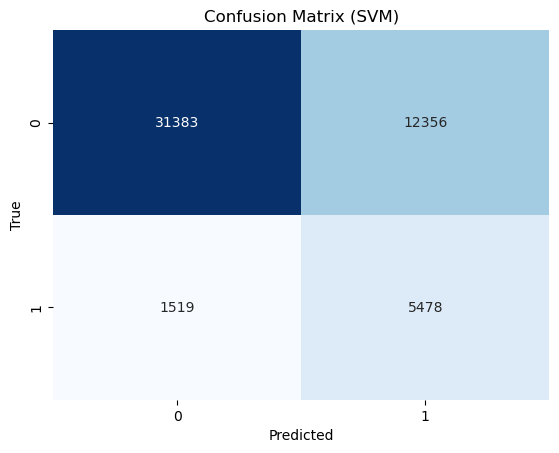

In [18]:
# Predictions
y_pred = svm_best.predict(X_test_scaled)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM)')
plt.show()


In [19]:
# Initialize a dictionary to store the AUCs for SVM
auc_scores_svm = {}

# Calculate sample weights for handling imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

for column in X_train_scaled.columns:
    # Drop the current column from both training and testing sets
    X_train_dropped = X_train_scaled.drop(column, axis=1)
    X_test_dropped = X_test_scaled.drop(column, axis=1)
    
    # Initialize the SVM model
    svm = LinearSVC(dual=False)
    
    # Fit the SVM model on the dropped training set with sample weights
    svm.fit(X_train_dropped, y_train, sample_weight=sample_weights)
    
    # Calibrate the fitted SVM model to provide probability estimates
    calibrated_svm = CalibratedClassifierCV(svm, method='sigmoid', cv='prefit')
    calibrated_svm.fit(X_train_dropped, y_train)  # Calibration without sample weights
    
    # Predict probabilities for AUC using the calibrated SVM model
    y_pred_proba_svm = calibrated_svm.predict_proba(X_test_dropped)[:, 1]
    
    # Calculate AUC
    auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
    
    # Store the AUC score
    auc_scores_svm[column] = auc_svm

# Convert the auc_scores_svm dictionary to a DataFrame
auc_scores_svm_df = pd.DataFrame(list(auc_scores_svm.items()), columns=['Feature Dropped', 'AUC'])
auc_scores_svm_df_sorted = auc_scores_svm_df.sort_values(by='AUC', ascending=True)


auc_scores_svm_df_sorted.head(10)

,Feature Dropped,AUC
12,GeneralHealth,0.811765
2,BMI,0.814070
0,HighBP,0.820049
1,HighChol,0.821593
9,HeavyDrinker,0.825793
19,Age 30-34,0.826084
20,Age 35-39,0.826133
18,Age 25-29,0.826437
16,Male,0.826450
17,Age 18-24,0.826825


/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/1056510200.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC', y='Feature Dropped', data=auc_scores_svm_df_sorted.head(10), palette='Blues_d')


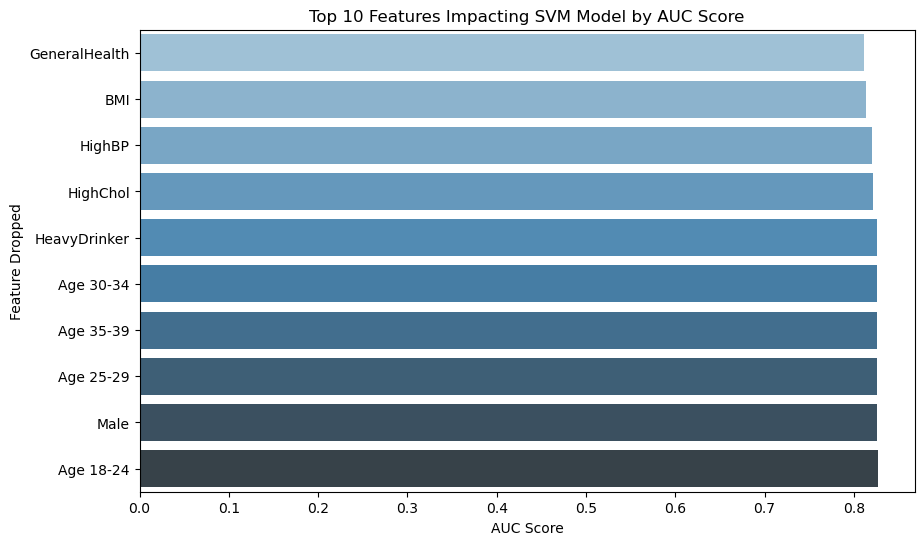

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Feature Dropped', data=auc_scores_svm_df_sorted.head(10), palette='Blues_d')
plt.title('Top 10 Features Impacting SVM Model by AUC Score')
plt.xlabel('AUC Score')
plt.ylabel('Feature Dropped')
plt.show()

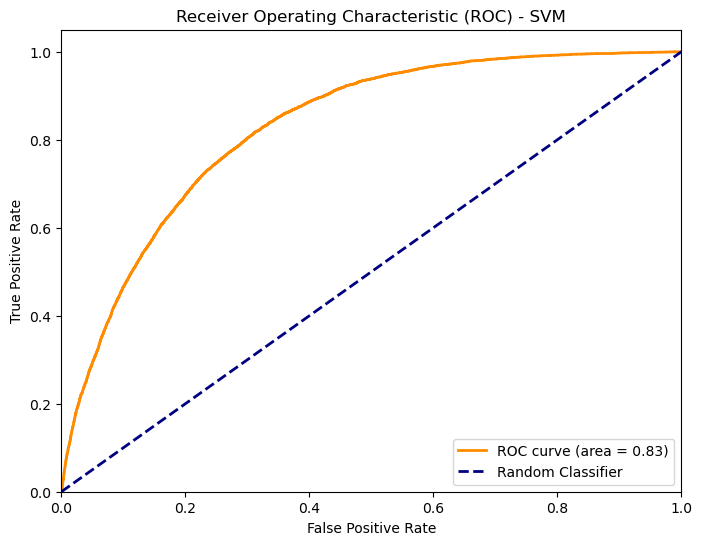

In [21]:
# Calculate decision scores
y_scores = svm_best.decision_function(X_test_scaled)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC
roc_auc_svm = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = "Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - SVM')
plt.legend(loc="lower right")
plt.show()


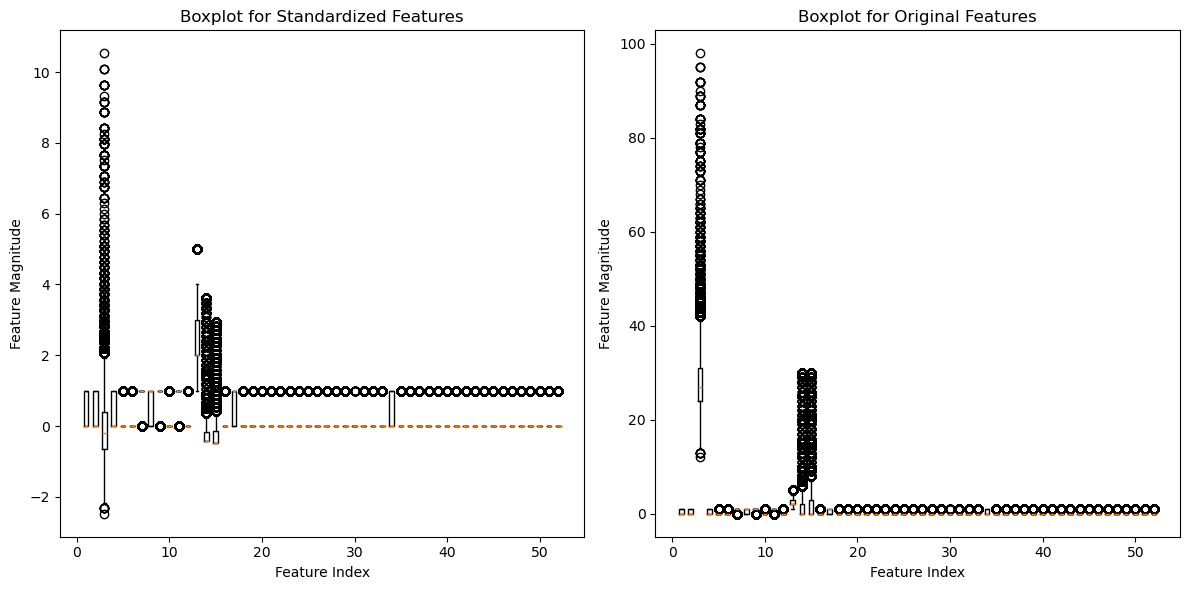

In [22]:
# Seeing how the standardized and unstandardized features differ

plt.figure(figsize=(12, 6))

# Plot for standardized features
plt.subplot(1, 2, 1)
plt.boxplot(X_test_scaled, manage_ticks=False)
plt.xlabel("Feature Index")
plt.ylabel("Feature Magnitude")
plt.title("Boxplot for Standardized Features")

# Plot for original features
plt.subplot(1, 2, 2)
plt.boxplot(X_test, manage_ticks=False)
plt.xlabel("Feature Index")
plt.ylabel("Feature Magnitude")
plt.title("Boxplot for Original Features")

plt.tight_layout()
plt.show()


# Question 3

In [23]:
# Define the model
clf = DecisionTreeClassifier(criterion='gini', class_weight= "balanced")

# Define the parameters grid
param_grid = {'max_depth': range(1, 21)}

# Scoring function
scorer = make_scorer(accuracy_score)

# GridSearchCV search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best max_depth value
best_max_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth value: {best_max_depth}")


best_score = grid_search.best_score_
print(f"Best cross-validated accuracy: {best_score:.3f}\n")

# Re-train the model with the best max_depth value
clf_best = DecisionTreeClassifier(criterion='gini', max_depth=best_max_depth, class_weight= "balanced")
clf_best.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred_best = clf_best.predict(X_test_scaled)
acc_best = accuracy_score(y_test, y_pred_best)
mcc_dt = matthews_corrcoef(y_test, y_pred_best)

y_pred_proba_dt = clf_best.predict_proba(X_test_scaled)[:, 1]

print(f'Decision Tree validation accuracy with best max_depth = {best_max_depth}: {100*acc_best:.2f}%')
print(f"Matthews Correlation Coefficient with best max_depth = {best_max_depth}: {round(mcc_dt,4)}\n")

acc_training_dt = round(clf_best.score(X_train_scaled, y_train),4)
acc_test_dt = round(clf_best.score(X_test_scaled, y_test), 4)

print(f"Accuracy on training set with best max_depth: {acc_training_dt}")
print(f"Accuracy on test set with best max_depth: {acc_test_dt}")


Best max_depth value: 2
Best cross-validated accuracy: 0.763

Decision Tree validation accuracy with best max_depth = 2: 76.39%
Matthews Correlation Coefficient with best max_depth = 2: 0.3161

Accuracy on training set with best max_depth: 0.7632
Accuracy on test set with best max_depth: 0.7639


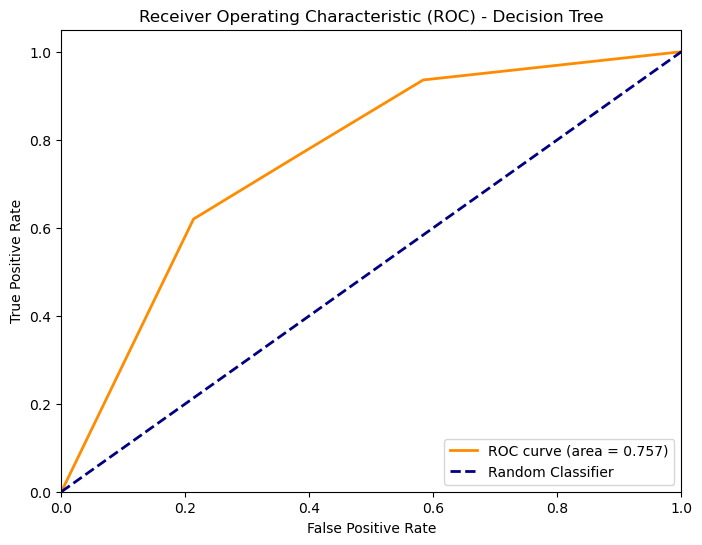

In [24]:
# Calculate the ROC curve points
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)

# Calculate the AUC (Area Under the Curve) for ROC
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_dt:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = "Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc="lower right")
plt.show()


In [25]:
# Extracting feature importances

feature_importances_dt = pd.DataFrame({'Feature': X.columns, 'Importance': clf_best.feature_importances_})
sorted_features_dt = feature_importances_dt.sort_values(by='Importance', ascending=False)
best_predictor_dt = sorted_features_dt.iloc[0]

print(f"The best predictor of diabetes is: {best_predictor_dt['Feature']} with an importance of {best_predictor_dt['Importance']:.3f}")

sorted_features_dt.head(10)

The best predictor of diabetes is: HighBP with an importance of 0.649


,Feature,Importance
0,HighBP,0.649431
12,GeneralHealth,0.350569
39,$35k-$50k,0.000000
29,Kindergarten,0.000000
30,Elementary School,0.000000
31,Some High School,0.000000
32,GED,0.000000
33,College Graduate,0.000000
34,Below $10k,0.000000
35,$10k-$15k,0.000000


/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/2874279861.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_features_dt.head(5), x='Importance', y='Feature',  palette='Blues_d')


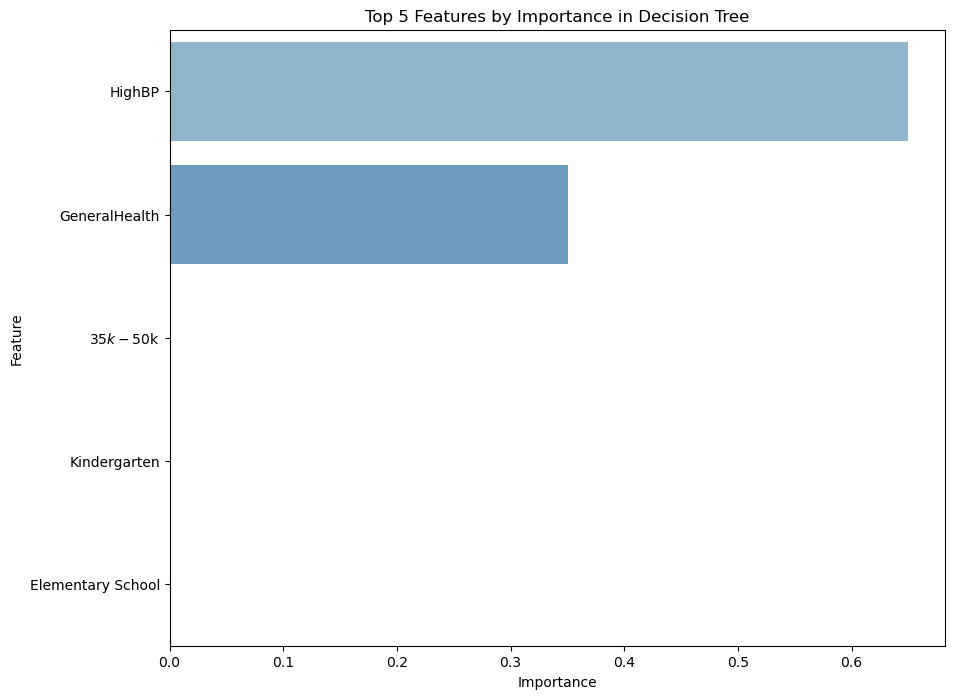

In [26]:
# Plot the top features
plt.figure(figsize=(10, 8))
sns.barplot(data=sorted_features_dt.head(5), x='Importance', y='Feature',  palette='Blues_d')
plt.title('Top 5 Features by Importance in Decision Tree')
plt.show()

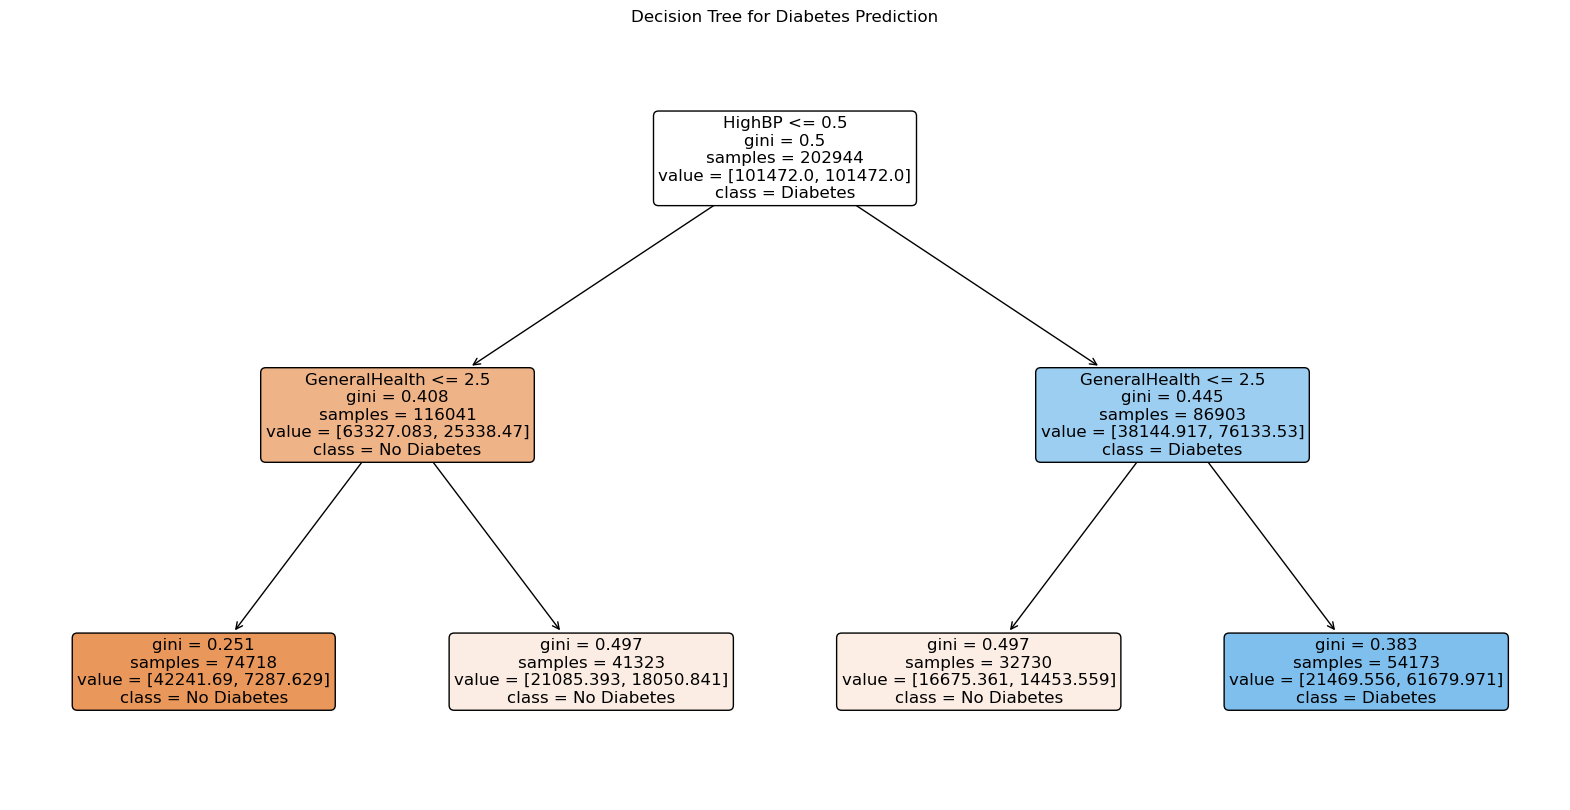

In [27]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf_best, filled=True, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], rounded=True, fontsize=12)
plt.title('Decision Tree for Diabetes Prediction')
plt.show()


              precision    recall  f1-score   support

           0       0.93      0.79      0.85     43739
           1       0.32      0.62      0.42      6997

    accuracy                           0.76     50736
   macro avg       0.62      0.70      0.64     50736
weighted avg       0.84      0.76      0.79     50736



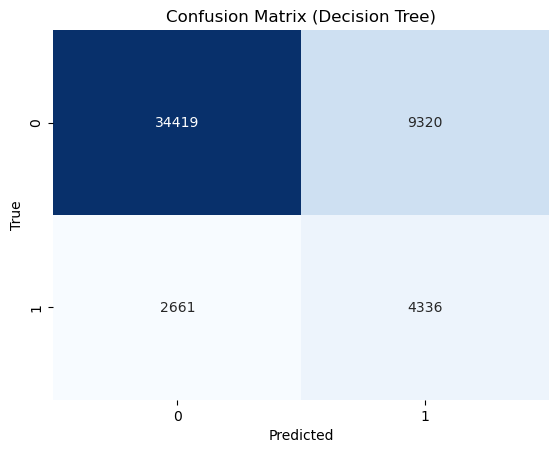

In [28]:
# Predictions
y_pred_dt = clf_best.predict(X_test_scaled)

# Classification Report
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()


# Question 4

AUC of the Random Forest model: 0.825
Matthews Correlation Coefficient for Random Forest model: 0.366

Accuracy on training set: 0.7565
Accuracy on test set: 0.7528

Accuracy of the Random Forest model: 0.753

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84     43739
           1       0.32      0.74      0.45      6997

    accuracy                           0.75     50736
   macro avg       0.64      0.75      0.65     50736
weighted avg       0.86      0.75      0.79     50736



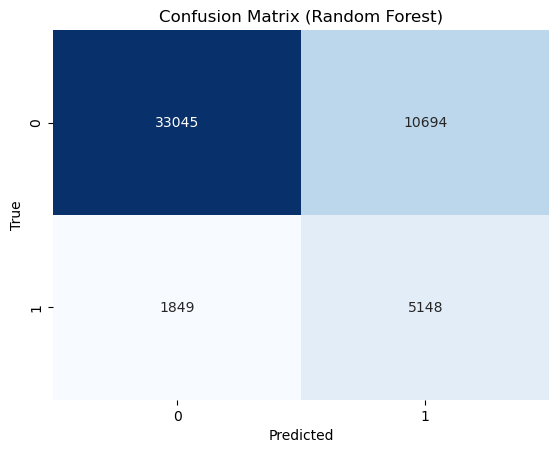

In [29]:
# Building Random Forest Classifier and choosing parameters
clf = RandomForestClassifier(class_weight = "balanced",    
                                n_estimators=500, 
                                max_samples=0.1, 
                                max_features= "sqrt",
                                max_depth = 10, 
                                bootstrap=True, 
                                criterion='gini')

clf.fit(X_train_scaled, y_train)


preds = clf.predict(X_test_scaled)

# Predict probabilities for AUC
y_pred_proba_rf = clf.predict_proba(X_test_scaled)[:, 1]

# Calculate AUC and MCC
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
mcc_rf = matthews_corrcoef(y_test, preds)
print(f"AUC of the Random Forest model: {auc_rf:.3f}")
print(f"Matthews Correlation Coefficient for Random Forest model: {mcc_rf:.3f}\n")


# Training and testing set accuracy
acc_training_rf = round(clf.score(X_train_scaled, y_train),4)
acc_test_rf = round(clf.score(X_test_scaled, y_test), 4)

print(f"Accuracy on training set: {acc_training_rf}")
print(f"Accuracy on test set: {acc_test_rf}\n")

# Accuracy
accuracy_rf = accuracy_score(y_test, preds)
print(f"Accuracy of the Random Forest model: {accuracy_rf:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, preds))

cm_rf = confusion_matrix(y_test, preds)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Random Forest)')
plt.show()


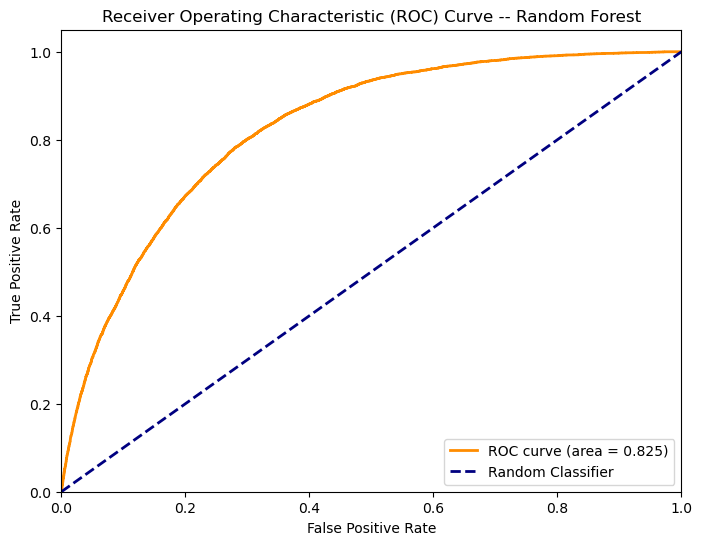

In [30]:
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = "Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve -- Random Forest')
plt.legend(loc="lower right")
plt.show()


In [31]:
# Feature Importance
feature_importances_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importances_rf.head(10)

,Feature,Importance
12,GeneralHealth,0.207165
0,HighBP,0.189100
2,BMI,0.130417
1,HighChol,0.086032
15,HardToClimbStairs,0.062710
14,PhysicalHealth,0.040853
5,Myocardial,0.037589
13,MentalHealth,0.016243
33,College Graduate,0.015072
6,PhysActivity,0.014061



The best predictor of diabetes is: GeneralHealth with an importance of 0.207


/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/2959729053.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(10), palette='Blues_d')


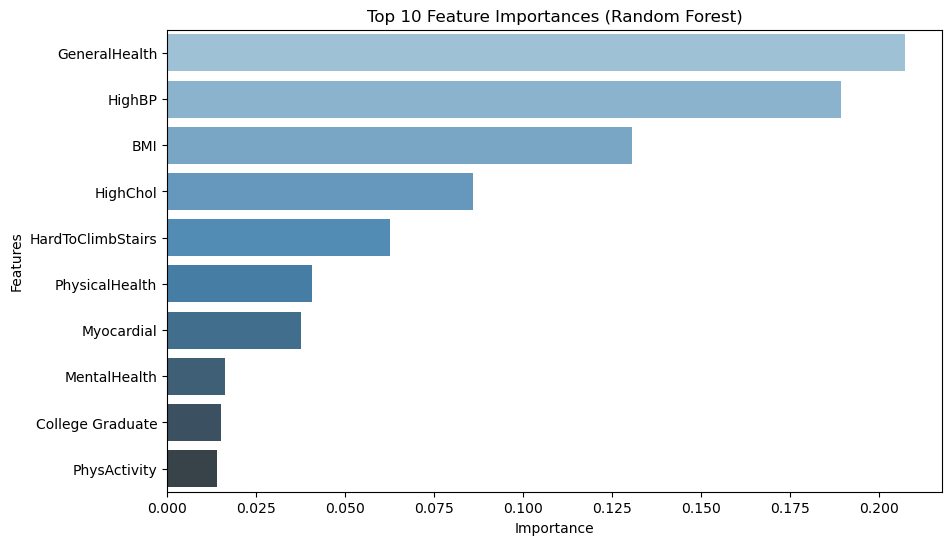

In [32]:
# Identifying the best predictor

best_predictor_rf = feature_importances_rf.iloc[0]['Feature']
print(f"\nThe best predictor of diabetes is: {best_predictor_rf} with an importance of {feature_importances_rf.iloc[0]['Importance']:.3f}")

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(10), palette='Blues_d')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Question 5

In [33]:
estimator = DecisionTreeClassifier(max_depth=3, class_weight="balanced")

# Building AdaBoost model
bdt = AdaBoostClassifier(
    estimator=estimator,
    algorithm="SAMME",
    n_estimators=200,
    learning_rate=1
)

# Fitting the data to the model
bdt.fit(X_train_scaled, y_train)

preds = bdt.predict(X_test_scaled)

# Predict probabilities for AUC
y_pred_proba_ab = bdt.predict_proba(X_test_scaled)[:, 1]

# AUC and MCC
auc_ab = roc_auc_score(y_test, y_pred_proba_ab)
mcc_ab = matthews_corrcoef(y_test, preds)

print(f"AUC of the AdaBoost model: {auc_ab:.3f}")
print(f"Matthews Correlation Coefficient for AdaBoost model: {mcc_ab:.3f}\n")

# Accuracy
acc_train_ab = round(accuracy_score(y_train, bdt.predict(X_train_scaled)), 4)
acc_test_ab = round(accuracy_score(y_test, preds), 4)

print(f"Accuracy on training set: {acc_train_ab}")
print(f"Accuracy on test set: {acc_test_ab}")


AUC of the AdaBoost model: 0.792
Matthews Correlation Coefficient for AdaBoost model: 0.345

Accuracy on training set: 0.7543
Accuracy on test set: 0.7558


In [34]:
# Finding the best predictor by for AdaBoost by dropping one variable and computing the AUC score. The left out variable associated with the highest
# drop in AUC score will be considered the best predictor

# Initialize
auc_scores = {}

# Iterate over each column to drop it and evaluate the model
for column in X.columns:
    # Drop the current column
    X_train_dropped = pd.DataFrame(X_train_scaled, columns=X.columns).drop(column, axis=1)
    X_test_dropped = pd.DataFrame(X_test_scaled, columns=X.columns).drop(column, axis=1)
    
    # Train the AdaBoost model
    bdt = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3, class_weight= "balanced"),
        algorithm="SAMME",
        n_estimators=100,
        learning_rate=1
    )
    bdt.fit(X_train_dropped, y_train)
    
    # Predict probabilities for AUC
    y_pred_proba_ab = bdt.predict_proba(X_test_dropped)[:, 1]
    auc_ab1 = roc_auc_score(y_test, y_pred_proba_ab)    
    auc_scores[column] = auc_ab1

most_important_feature = min(auc_scores, key=auc_scores.get)
most_significant_drop = auc_scores[most_important_feature]

print(f"The most important feature is: {most_important_feature} with an AUC of {most_significant_drop:.3f}")

The most important feature is: GeneralHealth with an AUC of 0.755


In [35]:
# Convert the auc_scores dictionary to a DataFrame
auc_scores_df = pd.DataFrame(list(auc_scores.items()), columns=['Feature Dropped', 'AUC'])
auc_scores_df_sorted = auc_scores_df.sort_values(by='AUC', ascending=True)
auc_scores_df_sorted.head(10)


,Feature Dropped,AUC
12,GeneralHealth,0.754943
2,BMI,0.762050
0,HighBP,0.764561
1,HighChol,0.779358
15,HardToClimbStairs,0.791517
16,Male,0.791738
14,PhysicalHealth,0.791832
31,Some High School,0.791891
32,GED,0.791891
33,College Graduate,0.791891


/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_80955/2667546315.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC', y='Feature Dropped', data=auc_scores_df_sorted.head(10), palette='Blues_d')


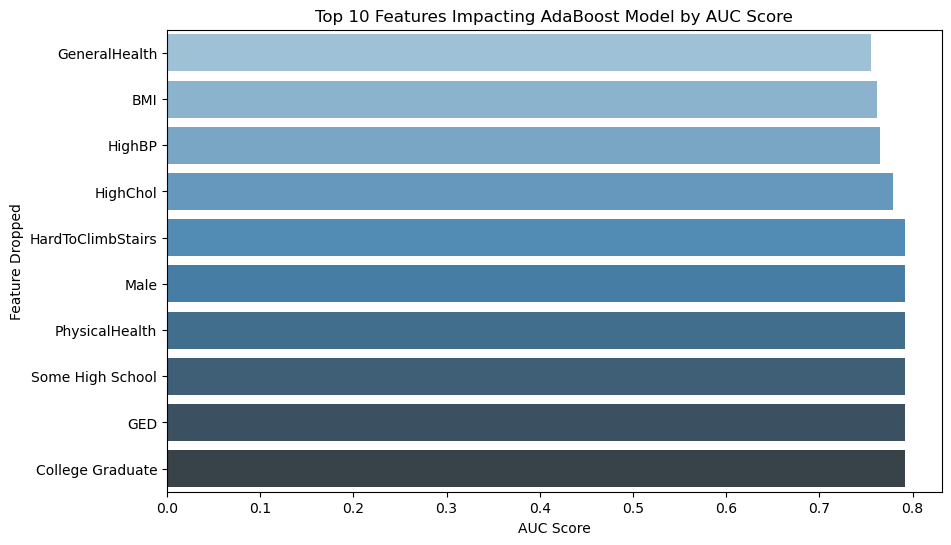

In [36]:
# Top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Feature Dropped', data=auc_scores_df_sorted.head(10), palette='Blues_d')
plt.title('Top 10 Features Impacting AdaBoost Model by AUC Score')
plt.xlabel('AUC Score')
plt.ylabel('Feature Dropped')
plt.show()

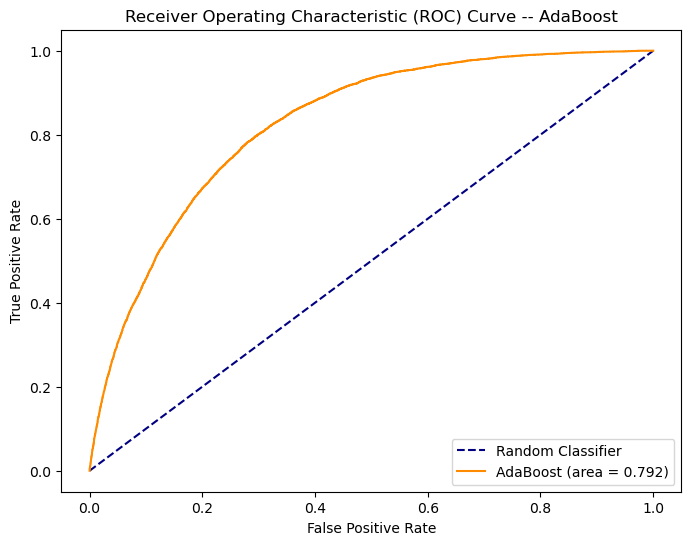

In [37]:
# ROC curve for AdaBoost

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color = "navy" ,linestyle = '--', label = "Random Classifier")
plt.plot(fpr, tpr, color = "darkorange", label=f'AdaBoost (area = {auc_ab:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve -- AdaBoost')
plt.legend(loc='lower right')
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84     43739
           1       0.32      0.69      0.44      6997

    accuracy                           0.76     50736
   macro avg       0.63      0.73      0.64     50736
weighted avg       0.85      0.76      0.79     50736



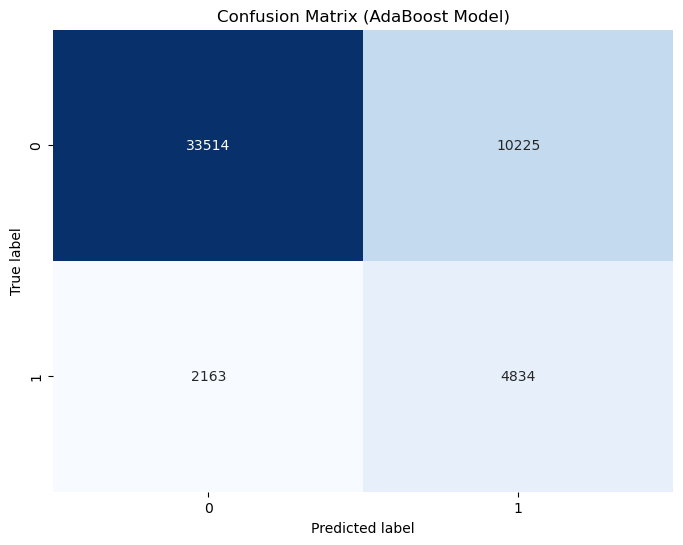

In [38]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, preds))

# Generate the confusion matrix
cm_ab = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ab, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (AdaBoost Model)')
plt.show()

# Model Evaluation

In [39]:
# Extracting best predictor
best_predictor_lr = auc_scores_lr_df_sorted.iloc[0]['Feature Dropped']
best_predictor_svm = auc_scores_svm_df_sorted.iloc[0]['Feature Dropped']
best_predictor_dt = sorted_features_dt.iloc[0]['Feature']  # Assuming 'Feature' is the column name
best_predictor_rf = feature_importances_rf.iloc[0]['Feature']  # Assuming the index is the feature name
best_predictor_ab = auc_scores_df_sorted.iloc[0]['Feature Dropped']


# Extracting second and third best predictors
second_best_predictor_lr = auc_scores_lr_df_sorted.iloc[1]['Feature Dropped']
third_best_predictor_lr = auc_scores_lr_df_sorted.iloc[2]['Feature Dropped']

second_best_predictor_svm = auc_scores_svm_df_sorted.iloc[1]['Feature Dropped']
third_best_predictor_svm = auc_scores_svm_df_sorted.iloc[2]['Feature Dropped']

second_best_predictor_dt = sorted_features_dt.iloc[1]['Feature']  # Assuming 'Feature' is the column name for decision tree
third_best_predictor_dt = sorted_features_dt.iloc[2]['Feature']

second_best_predictor_rf = feature_importances_rf.iloc[1]['Feature']  # Assuming 'Feature' is the column name for random forest
third_best_predictor_rf = feature_importances_rf.iloc[2]['Feature']

second_best_predictor_ab = auc_scores_df_sorted.iloc[1]['Feature Dropped']
third_best_predictor_ab = auc_scores_df_sorted.iloc[2]['Feature Dropped']

data = {
    'Model': ['Logistic', 'SVM', 'Decision Tree', 'Random Forest', 'AdaBoost'],
    'AUC': [auc_score1, roc_auc_svm, roc_auc_dt, auc_rf, auc_ab],
    'Training Accuracy': [acc_training_lr, acc_training_svm, acc_training_dt, acc_training_rf, acc_train_ab],
    'Test Accuracy': [acc_test_lr, acc_test_svm, acc_test_dt, acc_test_rf, acc_test_ab],
    'MCC': [round(mcc1,3), round(mcc_svm,3), round(mcc_dt,3), round(mcc_rf,3), round(mcc_ab,3)],
    'Precision (Diabetes)': [0.31, 0.31, 0.32, 0.33, 0.32],  # Precision for diabetes cases from classification reports
    'Recall (Diabetes)': [0.78, 0.78, 0.62, 0.74, 0.69],  # Recall for diabetes cases from classification reports
    'Best Predictor': [best_predictor_lr, best_predictor_svm, best_predictor_dt, best_predictor_rf, best_predictor_ab],
    '2nd Best Predictor': [second_best_predictor_lr, second_best_predictor_svm, second_best_predictor_dt, second_best_predictor_rf, second_best_predictor_ab],
    '3rd Best Predictor': [third_best_predictor_lr, third_best_predictor_svm, third_best_predictor_dt, third_best_predictor_rf, third_best_predictor_ab]
}

# Creating the DataFrame
model_performance_df = pd.DataFrame(data)
model_performance_df


,Model,AUC,Training Accuracy,Test Accuracy,MCC,Precision (Diabetes),Recall (Diabetes),Best Predictor,2nd Best Predictor,3rd Best Predictor
0,Logistic,0.827685,0.7311,0.7303,0.363,0.31,0.78,GeneralHealth,BMI,HighBP
1,SVM,0.827509,0.7272,0.7265,0.361,0.31,0.78,GeneralHealth,BMI,HighBP
2,Decision Tree,0.757389,0.7632,0.7639,0.316,0.32,0.62,HighBP,GeneralHealth,$35k-$50k
3,Random Forest,0.825139,0.7565,0.7528,0.366,0.33,0.74,GeneralHealth,HighBP,BMI
4,AdaBoost,0.791891,0.7543,0.7558,0.345,0.32,0.69,GeneralHealth,BMI,HighBP
